DataFrame Head:
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    flo

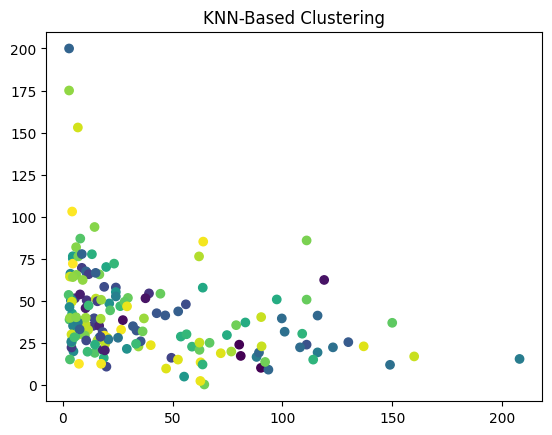

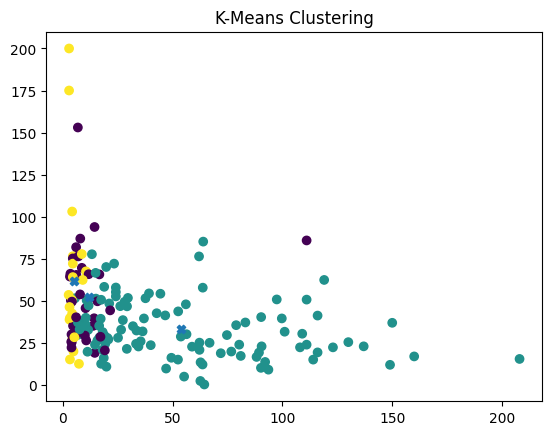

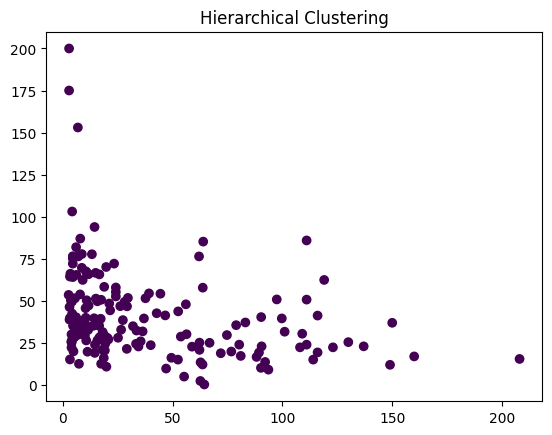

Silhouette Score - KNN: 0.9017076433501416
Silhouette Score - KMeans: 0.7450823653208921


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Silhouette Score - Hierarchical: nan


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ===============================
# 1. Load Dataset
# ===============================
df = pd.read_csv("data.csv")

# Display first few rows and info to understand data types
print("DataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
print(df.info())

# Automatically select only numeric columns for clustering
numeric_cols = df.select_dtypes(include=np.number).columns
X = df[numeric_cols].values

# If last column is label, uncomment next line
# data = data[:, :-1]

n_samples, n_features = X.shape


# ===============================
# 2. Distance Function
# ===============================
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


# ===============================
# 3. KNN-Based Clustering
# ===============================
def knn_clustering(X, k=3):
    n = len(X)
    labels = -1 * np.ones(n)
    cluster_id = 0

    for i in range(n):
        if labels[i] != -1:
            continue

        labels[i] = cluster_id
        distances = []

        for j in range(n):
            if i != j:
                distances.append((euclidean_distance(X[i], X[j]), j))

        distances.sort()
        neighbors = distances[:k]

        for _, idx in neighbors:
            labels[idx] = cluster_id

        cluster_id += 1

    return labels


# ===============================
# 4. K-Means Clustering
# ===============================
def kmeans(X, k=3, max_iter=100):
    n = len(X)
    centroids = X[np.random.choice(n, k, replace=False)]

    for _ in range(max_iter):
        clusters = [[] for _ in range(k)]

        for x in X:
            dists = [euclidean_distance(x, c) for c in centroids]
            clusters[np.argmin(dists)].append(x)

        new_centroids = []
        for cluster in clusters:
            if len(cluster) > 0:
                new_centroids.append(np.mean(cluster, axis=0))
            else:
                new_centroids.append(X[np.random.randint(0, n)])

        new_centroids = np.array(new_centroids)

        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    labels = []
    for x in X:
        dists = [euclidean_distance(x, c) for c in centroids]
        labels.append(np.argmin(dists))

    return np.array(labels), centroids


# ===============================
# 5. Hierarchical Clustering
# ===============================
def hierarchical_clustering(X, k=3):
    n = len(X)
    # Each point starts as its own cluster, represented by a list of point indices
    clusters = [[i] for i in range(n)]

    while len(clusters) > k:
        min_dist = float("inf")
        c1_idx, c2_idx = -1, -1  # Indices of clusters to merge in the 'clusters' list

        # Find the two closest clusters (single linkage)
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                # Calculate distance between clusters[i] and clusters[j]
                # Using single linkage (minimum distance between any two points)
                cluster_distance = float("inf")
                for p_point_idx in clusters[i]:
                    for q_point_idx in clusters[j]:
                        dist = euclidean_distance(X[p_point_idx], X[q_point_idx])
                        if dist < cluster_distance:
                            cluster_distance = dist

                if cluster_distance < min_dist:
                    min_dist = cluster_distance
                    c1_idx, c2_idx = i, j

        # Merge the two closest clusters
        if c1_idx != -1 and c2_idx != -1:
            clusters[c1_idx].extend(clusters[c2_idx])
            clusters.pop(c2_idx)
        else:
            # Should not happen if there are more than k clusters, but as a safeguard
            break

    # Assign final sequential integer labels (0 to k-1) to the remaining k clusters
    final_labels = np.zeros(n, dtype=int)
    for cluster_id, cluster_members_indices in enumerate(clusters):
        for point_idx in cluster_members_indices:
            final_labels[point_idx] = cluster_id

    return final_labels


# ===============================
# 6. Silhouette Score
# ===============================
def silhouette_score(X, labels):
    scores = []

    for i in range(len(X)):
        same_cluster = X[labels == labels[i]]
        other_cluster = X[labels != labels[i]]

        if len(same_cluster) <= 1:
            scores.append(0)
            continue

        a = np.mean([euclidean_distance(X[i], x) for x in same_cluster])
        b = np.mean([euclidean_distance(X[i], x) for x in other_cluster])

        scores.append((b - a) / max(a, b))

    return np.mean(scores)


# ===============================
# 7. Run Algorithms
# ===============================
labels_knn = knn_clustering(X, k=3)
labels_km, centers = kmeans(X, k=3)
labels_hc = hierarchical_clustering(X, k=3)


# ===============================
# 8. Visualization
# ===============================
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels_knn)
plt.title("KNN-Based Clustering")
plt.show()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels_km)
plt.scatter(centers[:, 0], centers[:, 1], marker='X')
plt.title("K-Means Clustering")
plt.show()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels_hc)
plt.title("Hierarchical Clustering")
plt.show()


# ===============================
# 9. Evaluation
# ===============================
print("Silhouette Score - KNN:", silhouette_score(X, labels_knn))
print("Silhouette Score - KMeans:", silhouette_score(X, labels_km))
print("Silhouette Score - Hierarchical:", silhouette_score(X, labels_hc))